## Classificando textos com machine learning

Neste notebook você aprenderá como classificar textos usando modelos de machine learning. Contaremos com dois algoritmos diferentes para gerar nosso modelo: Um SVM (por meio do estimador SGDClassifier) e uma rede neural Perceptron Multicamadas. Iremos experimentar um estimador de cada vez, para averiguar a performance de cada um no conjunto de dados validação. Em seguida, usaremos nosso modelo para fazer predições em dados que não foram vistos no conjunto de treino. Para treinar o modelo, usaremos o data set 20 Newsgroups.

## O Data set 20 Newsgroups

<img src="images/20newsgroups.png">

É um conjunto de dados contendo aproximadamente 20k documentos, divididos em cerca de 20 categorias. É um data set popular e conhecido pelo seu uso tarefas de classificação de textos em machine learning. Os conteúdos do data set estão separados por categoria e algumas destas categorias são muito próximas: ***comp.sys.ibm.pc.hardware*** / ***comp.sys.mac.hardware***. Há outras categorias que não possuem quaisquer semelhanças: ***rec.autos*** / ***talk.politics.misc***. Nosso objetivo aqui é obter um modelo capaz de classificar textos em algumas destas categorias.

## Importando nossas classes, o dataset e demais funções

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

# um classificador linear que utiliza o Gradiente Descendente Estocástico como método de treino. Por padrão, utiliza o estimador SVM.
from sklearn.linear_model import SGDClassifier
# Uma rede neural Perceptron Multicamadas
from sklearn.neural_network import MLPClassifier

from sklearn import metrics

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Limitando a quantidade de categorias e obtendo os dados de treino

Apenas por uma questão de agilidade, iremos reduzir a quantidade de dados a serem processados. Conseguiremos isto ao limitar o número de categorias em apenas duas. Nosso modelo classificará textos na área de ***política*** e ***automobilismo***. Você pode escolher qualquer uma das categorias ilustradas na imagem anterior, ou utilizar todas elas :-).

In [2]:
categories = ['talk.politics.misc', 'rec.autos']
twenty_train = fetch_20newsgroups(subset='train',categories=categories, shuffle=True, random_state=42)

## Obtendo alguns feedbacks sobre os dados

In [3]:
# Nomes das categorias
print(twenty_train.target_names)

['rec.autos', 'talk.politics.misc']


In [4]:
# O scikit-learn carrega os rótulo como um array de inteiros....
twenty_train.target[:10]

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 1])

In [5]:
# Mas, é possível visualizar os nomes das categorias da seguinte forma
for t in twenty_train.target[:10]:
    print(twenty_train.target_names[t])

talk.politics.misc
talk.politics.misc
talk.politics.misc
rec.autos
talk.politics.misc
talk.politics.misc
rec.autos
talk.politics.misc
talk.politics.misc
talk.politics.misc


## Treinando o classificador

Dados textuais representam valores discretos, e nosso classificador "só entende números". Nós precisamos converter os dados brutos, que estão em formato de texto, para uma formato numérico. Isto deve acontecer antes de podermos passar os dados para o nosso classificador.

É preciso levar em conta, ainda, que algumas palavras no corpus de treino serão muito presentes, como é o caso de preposições e artigos. Estas palavras tendem a se repetir em todos os documentos e não costumam carregar informação muito significativa para o que precisamos aqui. Nós utilizaremos a medidade TF-IDF para limitar a importância destas palavras que se repetem muito ao longo dos documentos, de maneira que elas não causem mais influência do que o necessário. TF-IDF significa **_frequência do termo–inverso da frequência nos documentos_** e se baseia na seguinte formula.

<img src="images/td-idf.png">

In [6]:
vectorizer = TfidfVectorizer()
X_train_tfidf_vectorize = vectorizer.fit_transform(twenty_train.data)

Abaixo, nós iniciamos o processo de treino do nosso classificador, o que corresponderia a ajustar o estimador aos dados que nós temos. Iremos testar dois estimadores: ***SGDClassifier*** e ***MLPClassifier***, que nada mais é do que uma rede neural Perceptron Multicamadas.

In [7]:
# Aqui nós treinamos o classificador
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
#clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(70, ), random_state=1, verbose=True)
clf.fit(X_train_tfidf_vectorize, twenty_train.target) 

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)

## Avaliando a performance

In [8]:
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)
docs_test = twenty_test.data

vect_transform = vectorizer.transform(docs_test)
predicted = clf.predict(vect_transform)


print(metrics.classification_report(twenty_test.target, predicted,target_names=twenty_test.target_names))

print(clf.classes_)

                    precision    recall  f1-score   support

         rec.autos       0.93      0.99      0.96       396
talk.politics.misc       0.99      0.90      0.94       310

          accuracy                           0.95       706
         macro avg       0.96      0.95      0.95       706
      weighted avg       0.95      0.95      0.95       706

[0 1]


***Matriz de confusão*** – usada para visualizar a performance de um classificador. As linhas da matriz indicam as classes que se espera obter corretamente por meio do modelo. As colunas indicam as classes que foram obtidas efetivamente. Cada célula contém o número de predições feitas pelo classificador, relativas ao contexto daquela célula específica.

In [9]:
confusion_matrix = confusion_matrix(twenty_test.target, predicted)
print(confusion_matrix)

[[392   4]
 [ 30 280]]


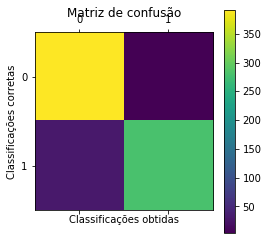

In [10]:
plt.matshow(confusion_matrix)
plt.title("Matriz de confusão")
plt.colorbar()
plt.ylabel("Classificações corretas")
plt.xlabel("Classificações obtidas")
plt.show()

## Predição em novos dados

In [11]:
docs_new = [
    'Wednesday morning, the legal team had appeared to turn back toward more discreet lawyering, with the announcement that Washington trial lawyer Emmet Flood would join the team inside the White House.',
    'By the time Rolls-Royce unveiled its one-of-a-kind Serenity Phantom at the 2015 Geneva Motor Show.'
]

X_new_tfidf_vectorize = vectorizer.transform(docs_new)

predicted = clf.predict(X_new_tfidf_vectorize)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))

'Wednesday morning, the legal team had appeared to turn back toward more discreet lawyering, with the announcement that Washington trial lawyer Emmet Flood would join the team inside the White House.' => talk.politics.misc
'By the time Rolls-Royce unveiled its one-of-a-kind Serenity Phantom at the 2015 Geneva Motor Show.' => rec.autos
